# Vizualization

## Import and clean the dataset

In [1]:
import pandas as pd
import numpy as np

PATH = "aggregatedData/3avrilDoubleGRU.csv"
df = pd.read_csv(PATH, header=0, delimiter=',')
df.rename(columns={'Unnamed: 0':'name', 'Unnamed: 1':'Metric','Unnamed: 2':'Horizontal_axis'},inplace=True)

NUMBER_OF_EPOCHS = 200

Create the columns based on the name:

In [2]:
def nameToCol(row):
    features = str(row['name']).split("-")
    for f in features:
        if "opti" in f:
            row[str(f[:4])] = str(f[4:])
        for i,caracter in enumerate(f):
            if caracter.isdigit():
                featureName = f[:i]
                try:
                    row[featureName] = int(f[i:])
                except:
                    row[featureName] = float(f[i:])
                break
    return(row)

df = df.apply(lambda x: nameToCol(x),axis=1)

Concatenate the epochs colums into one list of measurements:

In [3]:
def epochsToColumn(row):
    listOfMeasures = []
    for c in range(0,NUMBER_OF_EPOCHS):
        listOfMeasures.append(row[str(c)])
    row["measures"] = listOfMeasures  
    return(row)

df = df.apply(lambda x: epochsToColumn(x),axis=1)

Drop unecessary columns:

In [4]:
dropList = []
for i in range(0,NUMBER_OF_EPOCHS-1):
    dropList.append(str(i))
    
df = df.drop(columns=dropList)
df = df.rename(columns={str(NUMBER_OF_EPOCHS-1):'lastValue'})

In [5]:
df.head()

,name,Metric,Horizontal_axis,lastValue,nobs,opti,lr,doubleGRU,GRUnext,time,measures
0,nobs32-optiRMS-lr0.0005-doubleGRU512-GRUnext64...,val_loss,value,4.329522e-02,32,RMS,0.0005,512,64,1585899844,"[0.5383313894271851, 0.5058935284614563, 0.460..."
1,nobs32-optiRMS-lr0.0005-doubleGRU512-GRUnext64...,val_loss,wall_time,1.585902e+09,32,RMS,0.0005,512,64,1585899844,"[1585899868.63525, 1585899877.7796047, 1585899..."
2,nobs32-optiRMS-lr0.0005-doubleGRU512-GRUnext64...,val_D1_loss,value,1.329818e-02,32,RMS,0.0005,512,64,1585899844,"[0.2265210896730423, 0.13387306034564972, 0.15..."
3,nobs32-optiRMS-lr0.0005-doubleGRU512-GRUnext64...,val_D1_loss,wall_time,1.585902e+09,32,RMS,0.0005,512,64,1585899844,"[1585899868.635361, 1585899877.7796915, 158589..."
4,nobs32-optiRMS-lr0.0005-doubleGRU512-GRUnext64...,val_D2_loss,value,1.397044e-02,32,RMS,0.0005,512,64,1585899844,"[0.1955714374780655, 0.11087248474359512, 0.10..."


Uniques values:

In [6]:
for col in df:
    if str(col)!="time" and str(col)!="measures" and str(col)!="name" and str(col)!="lastValue":
        print(col,"\n",df[col].unique(),"\n")

Metric 
 ['val_loss' 'val_D1_loss' 'val_D2_loss' 'val_D3_loss'
 'val_D1_mean_absolute_error' 'val_D2_mean_absolute_error'
 'val_D3_mean_absolute_error' 'loss' 'D1_loss' 'D2_loss' 'D3_loss'
 'D1_mean_absolute_error' 'D2_mean_absolute_error'
 'D3_mean_absolute_error'] 

Horizontal_axis 
 ['value' 'wall_time'] 

nobs 
 [32] 

opti 
 ['RMS'] 

lr 
 [0.0005] 

doubleGRU 
 [512] 

GRUnext 
 [64] 



## Visualize

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [8]:
mpl.rcParams['figure.figsize'] = (16,7)

Select what we want to see:

In [9]:
dfViz = df[df["Horizontal_axis"] == "value"]
dfViz = dfViz.drop(columns=["Horizontal_axis"])
dfViz.head()

,name,Metric,lastValue,nobs,opti,lr,doubleGRU,GRUnext,time,measures
0,nobs32-optiRMS-lr0.0005-doubleGRU512-GRUnext64...,val_loss,0.043295,32,RMS,0.0005,512,64,1585899844,"[0.5383313894271851, 0.5058935284614563, 0.460..."
2,nobs32-optiRMS-lr0.0005-doubleGRU512-GRUnext64...,val_D1_loss,0.013298,32,RMS,0.0005,512,64,1585899844,"[0.2265210896730423, 0.13387306034564972, 0.15..."
4,nobs32-optiRMS-lr0.0005-doubleGRU512-GRUnext64...,val_D2_loss,0.013970,32,RMS,0.0005,512,64,1585899844,"[0.1955714374780655, 0.11087248474359512, 0.10..."
6,nobs32-optiRMS-lr0.0005-doubleGRU512-GRUnext64...,val_D3_loss,0.016027,32,RMS,0.0005,512,64,1585899844,"[0.11623886972665788, 0.2611479461193085, 0.20..."
8,nobs32-optiRMS-lr0.0005-doubleGRU512-GRUnext64...,val_D1_mean_absolute_error,0.084491,32,RMS,0.0005,512,64,1585899844,"[0.4548433125019074, 0.33628615736961365, 0.36..."


In [10]:
from scipy.ndimage.filters import gaussian_filter1d

def showGraph(toShow,title=" ",xaxis="Epoch",yaxis="???",smooth=False):
    for i, row in toShow.iterrows(): 
        # smooth the plot
        if smooth:
            ysmoothed = gaussian_filter1d(row["measures"], sigma=2)
            plt.plot(ysmoothed)
        else:
            plt.plot(row["measures"])        
    # axes
    axes = plt.gca()
    axes.set_xlim()
    axes.set_ylim((0,0.1))
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.title(title)
    plt.legend(toShow["name"], title="From best to worst last result:")
    plt.show()
    
def showBestMetric(dfViz,metric,N=10):
    toShow = dfViz[dfViz["Metric"] == metric].nsmallest(N, ['lastValue']).sort_values(by=["lastValue"],ascending=True)
    showGraph(toShow,title = f'Best {N} runs ({metric})',xaxis="Epoch",yaxis=metric,smooth=True)

Best 10 final loss train:

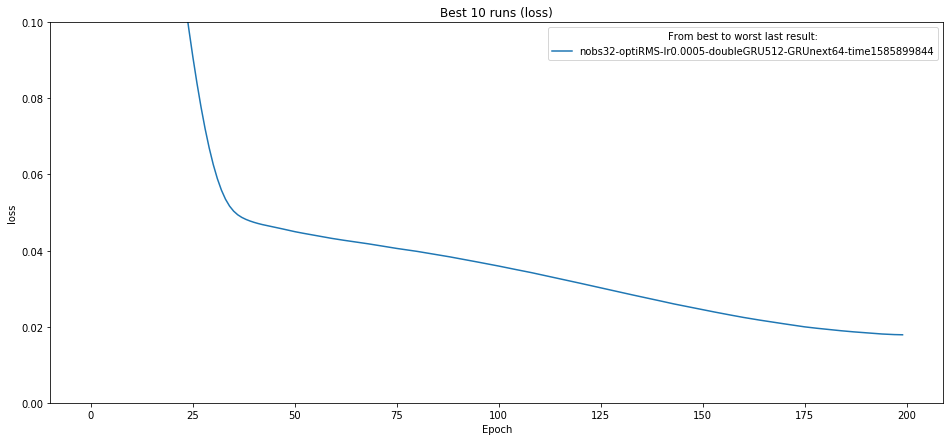

In [11]:
N = 10
metric= "loss"
showBestMetric(dfViz,metric,N)

Best N final validation loss train:

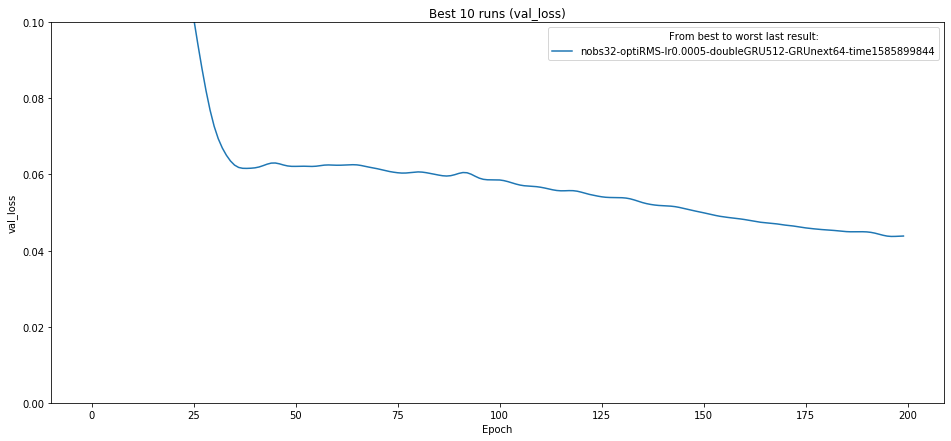

In [12]:
N = 10
metric= "val_loss"
showBestMetric(dfViz,metric,N)

## Stats

In [13]:
list_of_features = ["nobs","opti","doubleGRU","GRUnext"]

print(f"===Mean of the last result for the {N} best last result of each feature, group by feature and ordered by mean best result===")
for metric in ["loss","val_loss"]:
    # for each metric
    print("\n----==== {} ====----".format(metric))
    for feature in list_of_features:
        # for each feature of the model
        print("--- {} --".format(feature))
        dico = {}
        for unique in dfViz[feature].unique():
            # for each unique value
            dico[unique] = dfViz[dfViz[feature] == unique][dfViz["Metric"] == metric].nsmallest(N, ['lastValue'])["lastValue"].mean()
        # print the result for this feature
        orderKey = sorted(dico, key=dico.get)
        for k in orderKey:
            print(k,": ",round(dico[k],5))
        

===Mean of the last result for the 10 best last result of each feature, group by feature and ordered by mean best result===

----==== loss ====----
--- nobs --
32 :  0.01784
--- opti --
RMS :  0.01784
--- doubleGRU --
512 :  0.01784
--- GRUnext --
64 :  0.01784

----==== val_loss ====----
--- nobs --
32 :  0.0433
--- opti --
RMS :  0.0433
--- doubleGRU --
512 :  0.0433
--- GRUnext --
64 :  0.0433
